In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
import folium
from lovelyrita.data import read_data, column_map, to_geopandas, write_shapefile
from lovelyrita.clean import get_datetime, clean, impute_missing_times


column_map['[latitude]'] = 'latitude'
column_map['[longitude]'] = 'longitude'


plt.style.use('seaborn')

# Create neighborhood shape

In [4]:
# hand draw Chinatown boundary
geometry = Polygon([[-122.272536, 37.802353],
                    [-122.274339, 37.799497],
                    [-122.269414, 37.797573],
                    [-122.267536, 37.800388]])

neighborhood = gpd.GeoDataFrame({'geometry': [geometry,],
                                 'name': ['Chinatown',]}, crs={'init' :'epsg:4326'})

# Load citations

In [5]:
data_paths = ["/data/lovely-rita/new/2012complete-output.csv",
              "/data/lovely-rita/new/2013complete-output.csv",
              "/data/lovely-rita/new/2014complete-output.csv",
              "/data/lovely-rita/new/2015complete-output.csv",
              "/data/lovely-rita/new/2016complete-output-2.csv"
             ]

In [14]:
citations = read_data(data_paths, column_map=column_map, clean=True)
citations = to_geopandas(citations)

# Select Chinatown citations

In [26]:
neighb = neighborhood.geometry.iloc[0]

selected_indices = [neighb.contains(c)
                    for c in citations.geometry.values]

selected_citations = citations.iloc[selected_indices]

In [16]:
# show neighborhood boundary on map
map = folium.Map([neighb.centroid.y, neighb.centroid.x], zoom_start=16)
map.choropleth(neighborhood.to_crs({'init': 'epsg:4326'}).to_json(), fill_opacity=0.1, line_weight=3)
map

In [17]:
order = selected_citations.groupby('violation_desc_long').street.count().sort_values(ascending=False).index

In [ ]:
selected_citations

In [20]:
pd.to_datetime(selected_citations.ticket_issue_datetime)

72     2012-01-03 04:30:00
1170   2012-01-04 09:32:00
1336   2012-01-04 10:20:00
1889   2012-01-04 13:58:00
1896   2012-01-04 14:01:00
Name: ticket_issue_datetime, dtype: datetime64[ns]

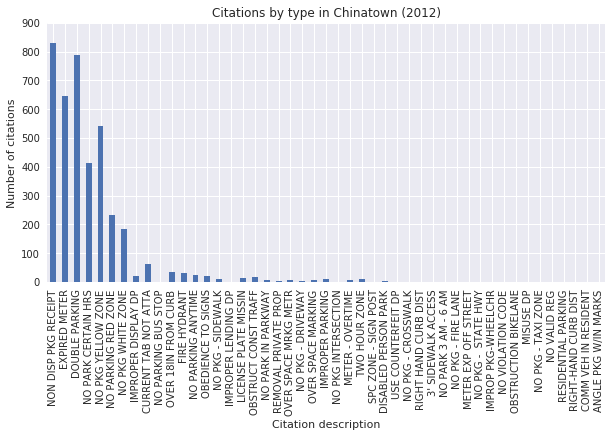

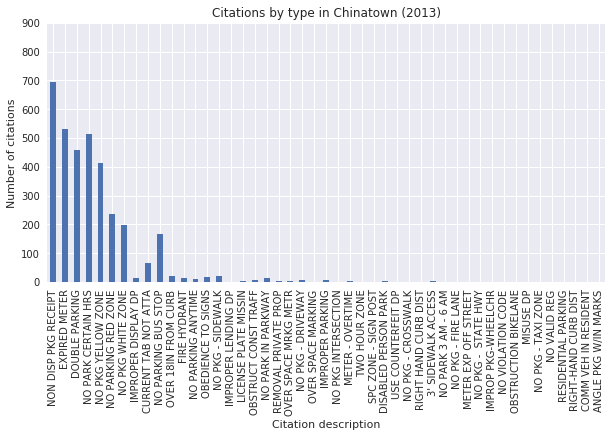

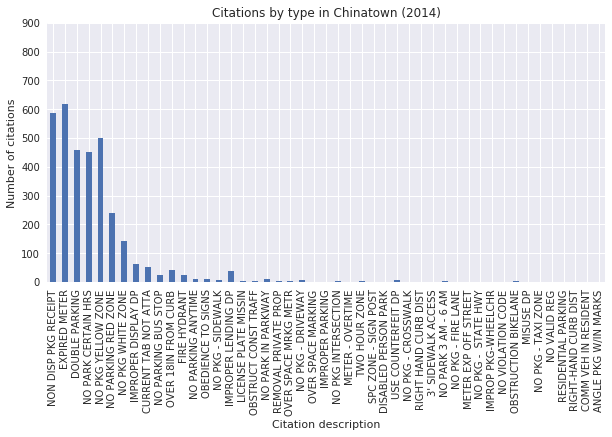

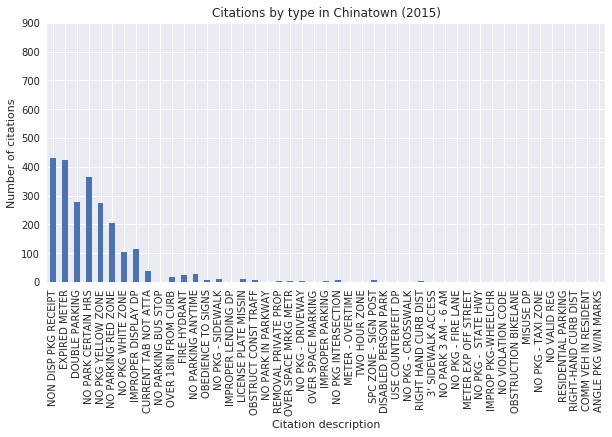

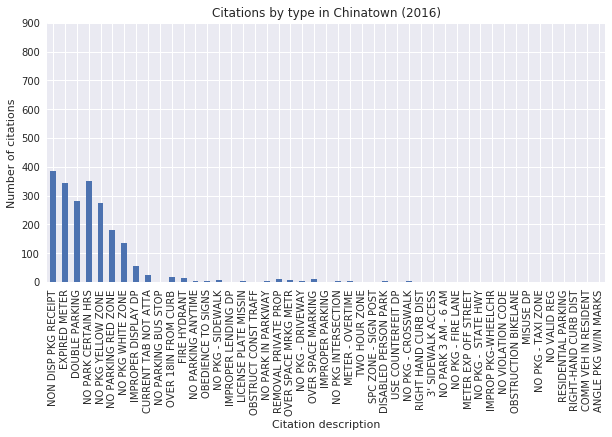

In [21]:
for year in [2012, 2013, 2014, 2015, 2016]:
    year_index = pd.to_datetime(selected_citations.ticket_issue_datetime).dt.year == year
    year_citations = selected_citations.loc[year_index]
    counts = year_citations.groupby('violation_desc_long').street.count()
    counts = counts[order]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = counts.plot(kind='bar', title='Citations by type in Chinatown ({})'.format(year), ylim=[0, 900])
    _ = ax.set_xlabel('Citation description')
    _ = ax.set_ylabel('Number of citations')
    fig.subplots_adjust(top=0.95, bottom=0.35)
    fig.savefig('/data/lovely-rita/figures/chinatown_citations_{}.png'.format(year))

# Save to a shapefile

In [22]:
write_shapefile(selected_citations, 'chinatown-citations.shp')